# The Time-Series Cross-Validation First ProtoType

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit


In [3]:
return_data = pd.read_csv(
    "data/config/20220831_last_dataset_monthly.csv",
    parse_dates=True
)

In [5]:
print(return_data.columns.tolist())

['Date', 'symbols', 'RRET1M', 'RRET2M', 'RRET3M', 'RRET6M', 'RRET12M', 'SRET1M', 'SRET2M', 'SRET3M', 'SRET6M', 'SRET12M', 'ISR3M', 'ISR6M', 'ISR12M', 'raw_ret_nextmonth', 'scaled_ret_nextmonth', 'ISC3M', 'ISC6M', 'ISC12M', 'ISR6M_nexmonth', 'ISR12M_nexmonth']


In [28]:
# Based on linear correlations and allowing for certain multicolinearity
naive_fs = [
    "Date", "symbols",              # categorical variables to help slicing and possibly enhance training capabilities
    'RRET3M', 'RRET6M', 'RRET12M', # raw cumulative returns over 3M, 6M, 12M
    'SRET3M', 'SRET6M', 'SRET12M', # scaled by EW volatility
    'ISR3M', 'ISR6M', 'ISR12M' # Sharpe Ratios (with Israelsen trick) over 3M, 6M, 12M
]

target = ['ISR12M_nexmonth']

In [47]:
# Discarding piece of data for pure testing purposes (last 3y)
X = return_data[return_data["Date"]<"2019-10-31"].loc[:,naive_fs]
y = return_data[return_data["Date"]<"2019-10-31"].loc[:,target]

## Tricking `TimeSeriesSplit()` For Rolling Window Scheme with Forward Validation

In [58]:
# Some Experiments with TimeSeriesSplit
instancies_by_date = return_data["symbols"].nunique()

test_size_ = instancies_by_date*12          # Fixing test_size to 1y each fold (split)
max_train_size_ = instancies_by_date*12*3   # Fixing max_train_size to 3y each fold (split)

tscv = TimeSeriesSplit(
    max_train_size = max_train_size_,
    test_size=test_size_,
    n_splits=9
)

print(tscv)

TimeSeriesSplit(gap=0, max_train_size=16884, n_splits=9, test_size=5628)


In [59]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

TRAIN: [    0     1     2 ... 16881 16882 16883] TEST: [16884 16885 16886 ... 22509 22510 22511]
TRAIN: [ 5628  5629  5630 ... 22509 22510 22511] TEST: [22512 22513 22514 ... 28137 28138 28139]
TRAIN: [11256 11257 11258 ... 28137 28138 28139] TEST: [28140 28141 28142 ... 33765 33766 33767]
TRAIN: [16884 16885 16886 ... 33765 33766 33767] TEST: [33768 33769 33770 ... 39393 39394 39395]
TRAIN: [22512 22513 22514 ... 39393 39394 39395] TEST: [39396 39397 39398 ... 45021 45022 45023]
TRAIN: [28140 28141 28142 ... 45021 45022 45023] TEST: [45024 45025 45026 ... 50649 50650 50651]
TRAIN: [33768 33769 33770 ... 50649 50650 50651] TEST: [50652 50653 50654 ... 56277 56278 56279]
TRAIN: [39396 39397 39398 ... 56277 56278 56279] TEST: [56280 56281 56282 ... 61905 61906 61907]
TRAIN: [45024 45025 45026 ... 61905 61906 61907] TEST: [61908 61909 61910 ... 67533 67534 67535]


In [50]:
X.shape[0]/(12*469)


12.0

In [60]:
5628/(12*469)

1.0

In [68]:
def plot_cv_indices(cv, X, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

        # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, X.shape[0]],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

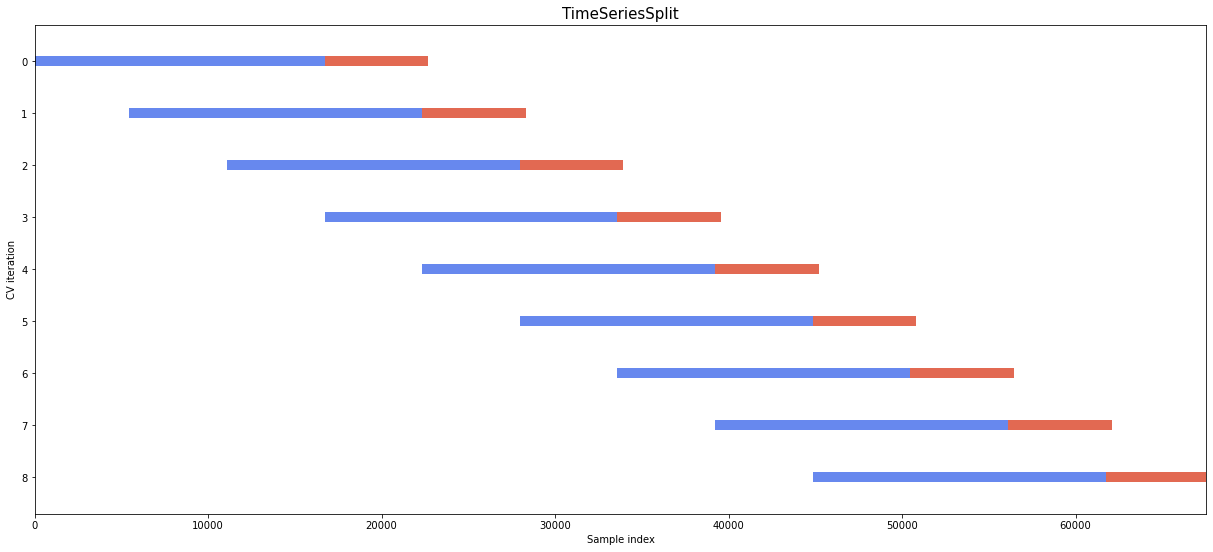

In [71]:
fig, ax = plt.subplots(figsize=(21,9))
plot_cv_indices(tscv, X, ax, 9);